In [135]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [136]:
data = pd.read_csv('virtual_matches_data.csv')

In [137]:
data.head()

,date,hour,home_team,away_team,score,home_goals,away_goals,datetime,odds_1,result,over_under_25,odds_over_under_25,goal_no_goal,odds_goal_no_goal
0,14-05-2025,15:34:00,Inghilterra,Messico,0-1,0,1,2025-05-14 15:34:00,250,2,"Under 2,5 Goal",129,NG,137
1,14-05-2025,15:28:00,Francia,Olanda,1-1,1,1,2025-05-14 15:28:00,319,X,"Under 2,5 Goal",129,GG,225
2,14-05-2025,15:22:00,Danimarca,Germania,0-1,0,1,2025-05-14 15:22:00,223,2,"Under 2,5 Goal",130,NG,138
3,14-05-2025,15:16:00,Croazia,Spagna,2-2,2,2,2025-05-14 15:16:00,323,X,"Over 2,5 Goal",247,GG,221
4,14-05-2025,15:10:00,Cile,Francia,1-0,1,0,2025-05-14 15:10:00,228,1,"Under 2,5 Goal",130,NG,138


In [138]:
export_model = data.head(50)
export_model.to_csv('export_model.csv', index=False)

In [139]:

export_model.columns.to_list()

['date',
 'hour',
 'home_team',
 'away_team',
 'score',
 'home_goals',
 'away_goals',
 'datetime',
 'odds_1',
 'result',
 'over_under_25',
 'odds_over_under_25',
 'goal_no_goal',
 'odds_goal_no_goal']

In [140]:
data.result.value_counts(normalize=True)

result
2    0.372897
1    0.355967
X    0.271136
Name: proportion, dtype: float64

Let's analyze the distances between draws (matches with result 'X') and create a table showing:
1. The distribution of games between consecutive draws in specified ranges
2. Calculate percentages and cumulative percentages for each range

In [141]:
# Find indices where result is 'X' (draws)
draw_indices = data[data['result'] == 'X'].index

# Calculate distances between consecutive draws
distances = np.diff(draw_indices)

# Define the ranges for analysis
bins = [0, 1, 3, 5, 7, 10, 12, 15, float('inf')]
labels = ['0-1', '1-3', '3-5', '5-7', '7-10', '10-12', '12-15', '15+']

# Create distribution table
dist_df = pd.DataFrame({
    'Range': labels,
    'Count': pd.cut(distances, bins=bins, labels=labels).value_counts(),
})

# Calculate percentages and cumulative percentages
total = dist_df['Count'].sum()
dist_df['Percentage'] = (dist_df['Count'] / total * 100).round()
dist_df['Cumulative %'] = dist_df['Percentage'].cumsum().round()

# Sort by the ranges in original order
dist_df = dist_df.reindex(labels)
dist_df

,Range,Count,Percentage,Cumulative %
0-1,0-1,1974,26.0,26.0
1-3,1-3,2634,35.0,61.0
3-5,3-5,1414,19.0,80.0
5-7,5-7,704,9.0,89.0
7-10,7-10,505,7.0,96.0
10-12,10-12,152,2.0,98.0
12-15,12-15,90,1.0,99.0
15+,15+,69,1.0,100.0


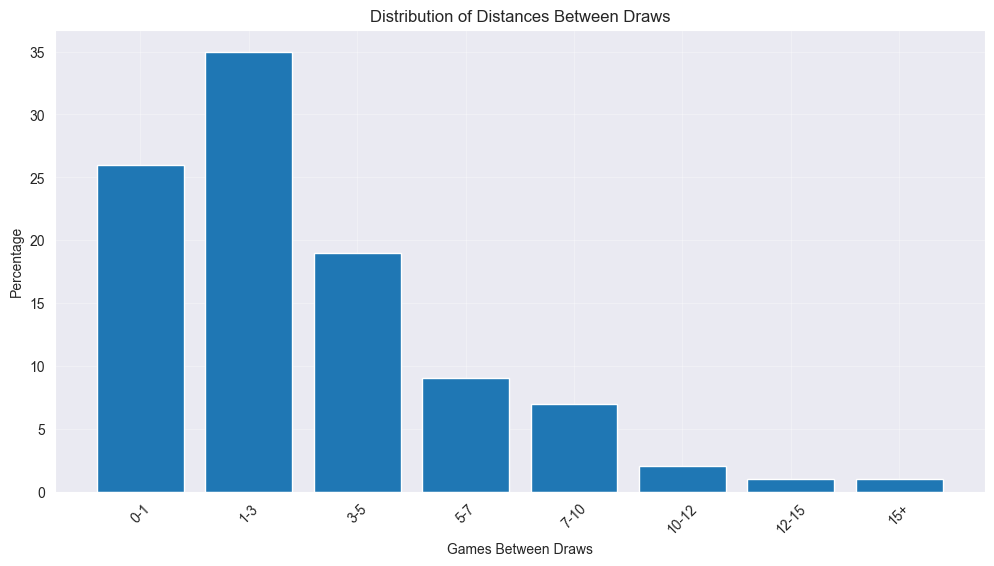

In [142]:
# Visualize the distribution
plt.figure(figsize=(12, 6))
plt.bar(dist_df.index, dist_df['Percentage'])
plt.title('Distribution of Distances Between Draws')
plt.xlabel('Games Between Draws')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.show()


In [143]:
data.head()

,date,hour,home_team,away_team,score,home_goals,away_goals,datetime,odds_1,result,over_under_25,odds_over_under_25,goal_no_goal,odds_goal_no_goal
0,14-05-2025,15:34:00,Inghilterra,Messico,0-1,0,1,2025-05-14 15:34:00,250,2,"Under 2,5 Goal",129,NG,137
1,14-05-2025,15:28:00,Francia,Olanda,1-1,1,1,2025-05-14 15:28:00,319,X,"Under 2,5 Goal",129,GG,225
2,14-05-2025,15:22:00,Danimarca,Germania,0-1,0,1,2025-05-14 15:22:00,223,2,"Under 2,5 Goal",130,NG,138
3,14-05-2025,15:16:00,Croazia,Spagna,2-2,2,2,2025-05-14 15:16:00,323,X,"Over 2,5 Goal",247,GG,221
4,14-05-2025,15:10:00,Cile,Francia,1-0,1,0,2025-05-14 15:10:00,228,1,"Under 2,5 Goal",130,NG,138


In [144]:
import itertools

# Analisi strategia ottimizzata con gestione errori e metriche aggiuntive
try:
    # Calcolo statistiche squadre
    team_stats = pd.DataFrame(index=data['home_team'].unique())

    for team in team_stats.index:
        home_matches = data[data['home_team'] == team]
        away_matches = data[data['away_team'] == team]

        draw_rate_home = (home_matches['result'] == 'X').mean()
        draw_rate_away = (away_matches['result'] == 'X').mean()
        total_matches = len(home_matches) + len(away_matches)
        avg_odds = home_matches['odds_1'].mean()

        # Calcolo metriche aggiuntive
        draw_streak_home = max([len(list(g)) for k, g in itertools.groupby(home_matches['result']) if k == 'X'] or [0])
        draw_streak_away = max([len(list(g)) for k, g in itertools.groupby(away_matches['result']) if k == 'X'] or [0])

        team_stats.loc[team, 'draw_rate_home'] = draw_rate_home
        team_stats.loc[team, 'draw_rate_away'] = draw_rate_away
        team_stats.loc[team, 'total_matches'] = total_matches
        team_stats.loc[team, 'avg_odds'] = avg_odds
        team_stats.loc[team, 'max_draw_streak'] = max(draw_streak_home, draw_streak_away)

    # Analisi sequenze e pattern
    no_draw_streaks = []
    current_streak = 0
    hourly_stats = {}

    for idx, row in data.iterrows():
        hour = int(row['hour'].split(':')[0])
        if hour not in hourly_stats:
            hourly_stats[hour] = {'total': 0, 'draws': 0}
        hourly_stats[hour]['total'] += 1
        if row['result'] == 'X':
            hourly_stats[hour]['draws'] += 1
            if current_streak > 0:
                no_draw_streaks.append(current_streak)
            current_streak = 0
        else:
            current_streak += 1

    if current_streak > 0:
        no_draw_streaks.append(current_streak)

    streak_stats = pd.Series(no_draw_streaks).value_counts().sort_index()

    # Calcolo probabilità dopo serie negative
    prob_after_streak = {}
    for streak_length in range(1, 11):
        matches_after_streak = len([x for x in no_draw_streaks if x >= streak_length])
        draws_after_streak = sum(1 for x in no_draw_streaks if x == streak_length)
        if matches_after_streak > 0:
            prob_after_streak[streak_length] = draws_after_streak / matches_after_streak

    # Analisi oraria
    hourly_draw_rates = {hour: stats['draws'] / stats['total']
                         for hour, stats in hourly_stats.items()}

    print("\n=== Analisi Dettagliata Avanzata ===")
    print("\nSquadre con maggiore probabilità di pareggio (home):")
    print(team_stats.sort_values('draw_rate_home', ascending=False).head())

    print("\nDistribuzione serie senza pareggi:")
    print(streak_stats.head(10))

    print("\nProbabilità pareggio dopo serie negative:")
    for streak, prob in prob_after_streak.items():
        print(f"Dopo {streak} partite: {prob:.2%}")

    print("\nOrari con maggiore probabilità di pareggio:")
    sorted_hours = sorted(hourly_draw_rates.items(), key=lambda x: x[1], reverse=True)
    for hour, rate in sorted_hours[:5]:
        print(f"Ora {hour:02d}:00 - {rate:.2%}")

    print("\nStrategia Ottimizzata:")
    print("1. Puntata base: 5€")
    print("2. Attendi 3-4 partite senza X")
    print("3. Verifica squadre con draw_rate > 27%")
    print("4. Massimo 2 raddoppi")
    print("5. Stop loss: -20€")
    print("6. Take profit: +15€")
    print("7. Pausa di 1 partita dopo ogni puntata")
    print("8. Privilegia orari con alta % di X")
    print("9. Evita squadre in serie positiva > 2 vittorie")
    print("10. Raddoppia solo se odds > 3.0")

except Exception as e:
    print(f"Errore nell'analisi: {str(e)}")



=== Analisi Dettagliata Avanzata ===

Squadre con maggiore probabilità di pareggio (home):
          draw_rate_home  draw_rate_away  total_matches    avg_odds  \
Belgio          0.317647        0.272222         1795.0  258.305882   
Italia          0.283591        0.261281         3410.0  256.580186   
Brasile         0.279279        0.289694         2690.0  255.724153   
Olanda          0.276952        0.269494         3410.0  257.321561   
Colombia        0.274325        0.334262         2692.0  254.759537   

          max_draw_streak  
Belgio                6.0  
Italia                6.0  
Brasile               6.0  
Olanda                5.0  
Colombia              6.0  

Distribuzione serie senza pareggi:
1     1540
2     1095
3      824
4      590
5      402
6      302
7      221
8      160
9      124
10      91
Name: count, dtype: int64

Probabilità pareggio dopo serie negative:
Dopo 1 partite: 27.65%
Dopo 2 partite: 27.18%
Dopo 3 partite: 28.08%
Dopo 4 partite: 27.96%
Dopo 5

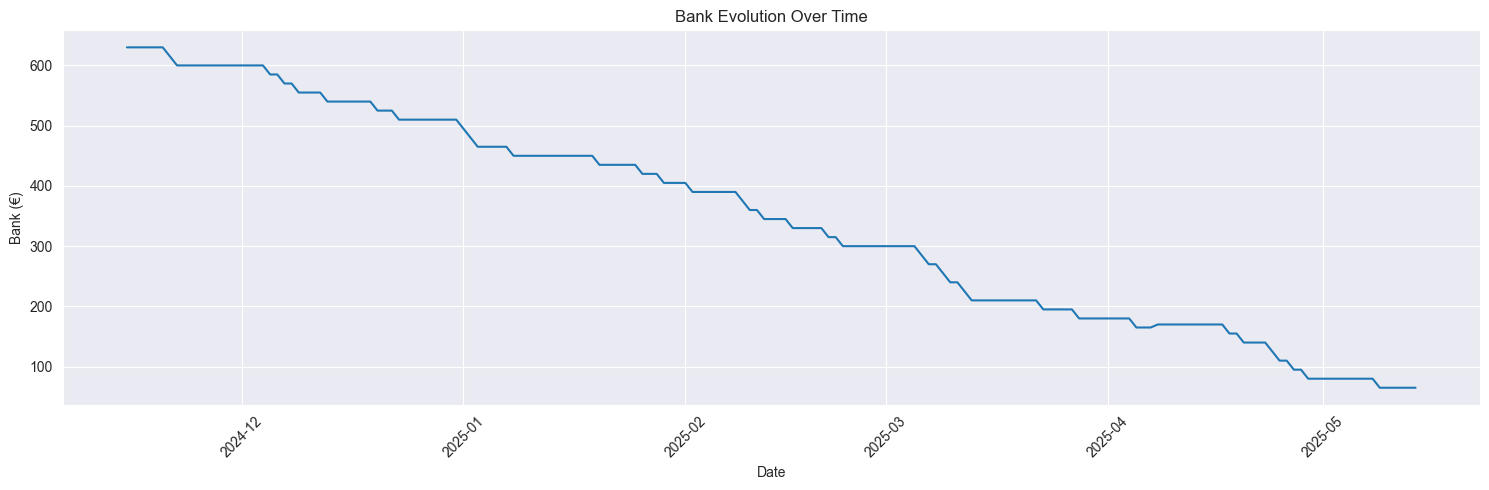


=== Simulation Results ===
Initial Bank: 50
Final Bank: 630
Total Profit: 580
Total Days: 181
Profitable Days: 39
Average Daily Profit: 3.20€
Max Daily Profit: 15
Max Daily Loss: -5
Max Bank: 630
Min Bank: 65


In [146]:
def simulate_betting_strategy(data, initial_bank=50, base_bet=5, max_doubles=2,
                              min_wait_games=3, max_wait_games=4, min_draw_rate=0.27,
                              stop_loss=-20, take_profit=15):
    results = []
    bank = initial_bank
    daily_profits = []
    current_day = None
    daily_profit = 0
    waiting_games = 0
    current_bet = base_bet
    doubles_count = 0

    # Calculate team stats
    team_stats = {}
    for team in set(data['home_team'].unique()) | set(data['away_team'].unique()):
        home_matches = data[data['home_team'] == team]
        away_matches = data[data['away_team'] == team]

        draw_rate_home = (home_matches['result'] == 'X').mean()
        draw_rate_away = (away_matches['result'] == 'X').mean()

        team_stats[team] = {
            'draw_rate_home': draw_rate_home if not pd.isna(draw_rate_home) else 0,
            'draw_rate_away': draw_rate_away if not pd.isna(draw_rate_away) else 0
        }

    # Convert date to datetime
    data['datetime'] = pd.to_datetime(data['date'], format='%d-%m-%Y')

    for idx, match in data.iterrows():
        match_date = match['datetime'].date()

        # Track daily profits
        if current_day is None:
            current_day = match_date
        elif current_day != match_date:
            daily_profits.append({'date': current_day, 'profit': daily_profit, 'final_bank': bank})
            daily_profit = 0
            current_day = match_date
            waiting_games = 0
            current_bet = base_bet
            doubles_count = 0

        # Check if we should reset after reaching stop loss or take profit
        if daily_profit <= stop_loss or daily_profit >= take_profit:
            waiting_games = 0
            current_bet = base_bet
            doubles_count = 0
            continue

        # Increment waiting counter
        waiting_games += 1

        # Check betting conditions
        home_team = match['home_team']
        away_team = match['away_team']

        home_draw_rate = team_stats[home_team]['draw_rate_home']
        away_draw_rate = team_stats[away_team]['draw_rate_away']

        conditions_met = (
                waiting_games >= min_wait_games and
                waiting_games <= max_wait_games and
                (home_draw_rate > min_draw_rate or away_draw_rate > min_draw_rate) and
                match['odds_1'] > 300  # odds > 3.0
        )

        if conditions_met:
            results.append({
                'date': match_date,
                'hour': match['hour'],
                'teams': f"{match['home_team']} vs {match['away_team']}",
                'bet': current_bet,
                'result': match['result'],
                'bank_before': bank,
                'daily_profit_before': daily_profit
            })

            if match['result'] == 'X':  # Win
                profit = current_bet * 3  # Assuming X odds around 3.0
                bank += profit
                daily_profit += profit
                current_bet = base_bet
                doubles_count = 0
            else:  # Loss
                bank -= current_bet
                daily_profit -= current_bet
                if doubles_count < max_doubles:
                    current_bet *= 2
                    doubles_count += 1
                else:
                    current_bet = base_bet
                    doubles_count = 0

            results[-1].update({
                'bank_after': bank,
                'daily_profit_after': daily_profit
            })

            waiting_games = 0

    # Add last day
    if current_day is not None:
        daily_profits.append({'date': current_day, 'profit': daily_profit, 'final_bank': bank})

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    daily_profits_df = pd.DataFrame(daily_profits)

    # Calculate statistics
    stats = {
        'Initial Bank': initial_bank,
        'Final Bank': bank,
        'Total Profit': bank - initial_bank,
        'Total Days': len(daily_profits_df),
        'Profitable Days': len(daily_profits_df[daily_profits_df['profit'] > 0]),
        'Average Daily Profit': daily_profits_df['profit'].mean(),
        'Max Daily Profit': daily_profits_df['profit'].max(),
        'Max Daily Loss': daily_profits_df['profit'].min(),
        'Max Bank': daily_profits_df['final_bank'].max(),
        'Min Bank': daily_profits_df['final_bank'].min()
    }

    # Plotting
    plt.figure(figsize=(15, 5))
    plt.plot(daily_profits_df['date'], daily_profits_df['final_bank'])
    plt.title('Bank Evolution Over Time')
    plt.xlabel('Date')
    plt.ylabel('Bank (€)')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Print statistics
    print("\n=== Simulation Results ===")
    for key, value in stats.items():
        print(f"{key}: {value:.2f}€" if isinstance(value, float) else f"{key}: {value}")

    return results_df, daily_profits_df, stats


# Run simulation
results_df, daily_profits_df, stats = simulate_betting_strategy(data)
